# Data Cleaning, EDA and Models
This notebook imports collected data from my selected subreddits and performs cleaning and EDA. Intital Models are built and tested.

## Imports

In [452]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

## Read in the data

In [399]:
unresolved = pd.read_csv('../data/unresolved.csv').drop(columns='Unnamed: 0')
#unresolved['subreddit'] = 'unresolved'
unresolved.head(2)

,author,awarders,created_utc,selftext,subreddit,title
0,TheBonesOfAutumn,[],1643236773,"On April 8th, 1981, 19-year-old David Huff dec...",UnresolvedMysteries,"In April of 1981, the body of 23-year-old Shar..."
1,Skoodilypoop666,[],1643233541,"In the fall of 2021, The small town of London ...",UnresolvedMysteries,“Whodunnit” the murder of 62 year old Bryan Mc...


In [400]:
unsolved = pd.read_csv('../data/unsolved.csv').drop(columns='Unnamed: 0')
#unsolved['subreddit'] = 'unsolved'
unsolved.head(2)

,author,awarders,created_utc,selftext,subreddit,title
0,amkakis,[],1643239264,NaN,UnsolvedMysteries,An 18 year old leaves home to retrieve a purse...
1,Once_a_TQ,[],1643227462,NaN,UnsolvedMysteries,Search continues for retired Cape Breton veter...


In [401]:
unsolved['selftext'].isna().sum()

1090

In [402]:
unsolved['awarders'].value_counts()

[]    1099
Name: awarders, dtype: int64

In [403]:
unresolved['awarders'].value_counts()

[]    1009
Name: awarders, dtype: int64

**'selftext' empty in UnsolvedMysteries posts, will focus on title only for now.**

## Data Cleaning

### Concat/Merge Data
Drop 'selftext', 'awarders' columns from both datasets and merge/concat them together

In [404]:
unsolved = unsolved.drop(columns=['awarders', 'selftext'])
unresolved = unresolved.drop(columns=['awarders', 'selftext'])

In [405]:
data = pd.concat([unsolved, unresolved], ignore_index=True)
data.head()

,author,created_utc,subreddit,title
0,amkakis,1643239264,UnsolvedMysteries,An 18 year old leaves home to retrieve a purse...
1,Once_a_TQ,1643227462,UnsolvedMysteries,Search continues for retired Cape Breton veter...
2,lexx999,1643224623,UnsolvedMysteries,"On December 31 2021, around 01:50, every trace..."
3,lexx999,1643224227,UnsolvedMysteries,"On December 31 2021, around 01:50, every trace..."
4,010010100100011001,1643216812,UnsolvedMysteries,McMartin Preschool Satanic abuse: 20-minute pr...


In [406]:
data.shape

(2108, 4)

### Drop duplicates

In [407]:
data.duplicated().sum()

1

In [408]:
data = data.drop_duplicates()

### Binarize target variable
UnresolvedMysteries == 1

UnsolvedMysteries == 0

In [409]:
data['subreddit'] = data['subreddit'].map(
    {
        'UnresolvedMysteries': 1,
        'UnsolvedMysteries': 0,
    }
)
data.head(2)

,author,created_utc,subreddit,title
0,amkakis,1643239264,0,An 18 year old leaves home to retrieve a purse...
1,Once_a_TQ,1643227462,0,Search continues for retired Cape Breton veter...


## EDA

### Let's add a length and word count based on title and examine distributions.

In [410]:
# Add title length in characters and get the mean
data['title_len'] = data['title'].str.len()
data['title_len'].mean()

99.33554817275747

In [411]:
# Add title length in words and get the mean
data['title_count'] = data['title'].map(lambda x: len(x.split()))
data['title_count'].mean()

16.843853820598007

### Add a sentiment score using TextBlob

In [412]:
# Add polarity
data['title_polarity'] = data['title'].map(lambda x: TextBlob(x).sentiment[0])

In [413]:
# Add subjectivity
data['title_subjectivity'] = data['title'].map(lambda x: TextBlob(x).sentiment[1])

In [414]:
# Sanity check
data.head(2)

,author,created_utc,subreddit,title,title_len,title_count,title_polarity,title_subjectivity
0,amkakis,1643239264,0,An 18 year old leaves home to retrieve a purse...,107,21,0.1,0.200
1,Once_a_TQ,1643227462,0,Search continues for retired Cape Breton veter...,67,10,-0.1,0.025


### Full data pairplot

''

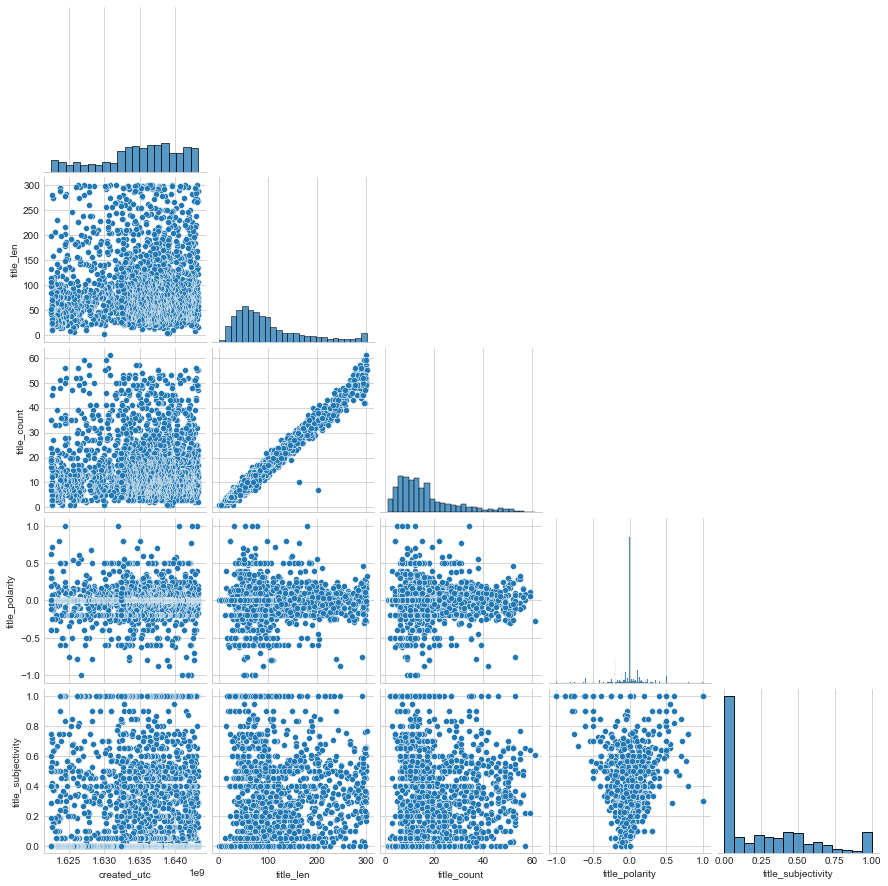

In [415]:
sns.pairplot(data.drop(columns='subreddit'), corner=True)
;

There are two outliers where title length doesn't align with title count. Nothing alarming though.

Title length and title count both appear normally distributed with right tail skew, which is expected: Mostly normal posts with some having longer titles.

It appears there is very little polarity and subjectivity in the titles, with some outliers. Will keep them just in case.

### Title Length, Word Count and Sentiment Comparissons
Let's compare title lengths, word counts and sentiments for each subreddit using visualizations

#### Title Lengths

''

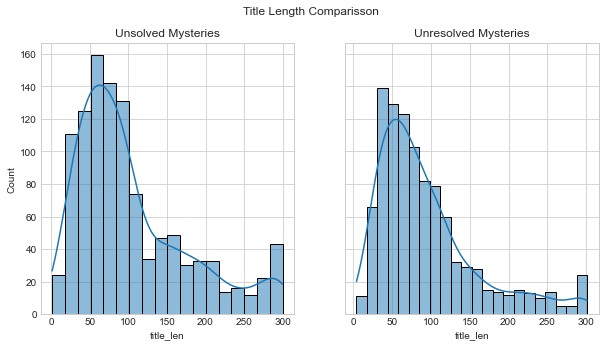

In [416]:
# With help from https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(data[data['subreddit'] == 0], x='title_len', kde=True, ax=axs[0])
sns.histplot(data[data['subreddit'] == 1], x='title_len', kde=True, ax=axs[1])

fig.suptitle('Title Length Comparisson')
axs[0].set_title('Unsolved Mysteries')
axs[1].set_title('Unresolved Mysteries')
plt.savefig('../presentation/plots/title_len.png')
;

#### Title Word Counts

''

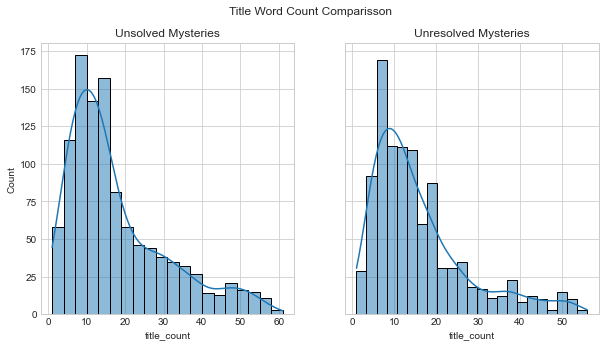

In [417]:
# With help from https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(data[data['subreddit'] == 0], x='title_count', kde=True, ax=axs[0])
sns.histplot(data[data['subreddit'] == 1], x='title_count', kde=True, ax=axs[1])

fig.suptitle('Title Word Count Comparisson')
axs[0].set_title('Unsolved Mysteries')
axs[1].set_title('Unresolved Mysteries')
plt.savefig('../presentation/plots/title_count.png')
;

#### Title Polarities

''

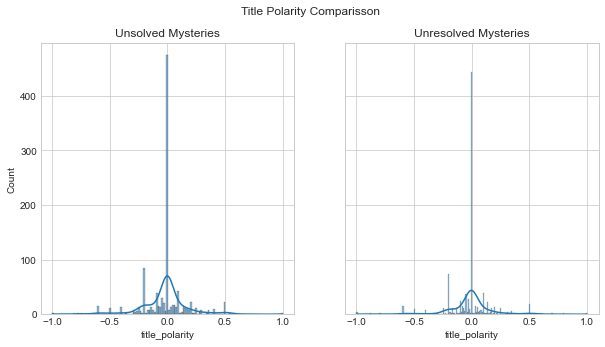

In [418]:
# With help from https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(data[data['subreddit'] == 0], x='title_polarity', kde=True, ax=axs[0])
sns.histplot(data[data['subreddit'] == 1], x='title_polarity', kde=True, ax=axs[1])

fig.suptitle('Title Polarity Comparisson')
axs[0].set_title('Unsolved Mysteries')
axs[1].set_title('Unresolved Mysteries')
plt.savefig('../presentation/plots/title_polarity.png')
;

#### Title Subjectivities

''

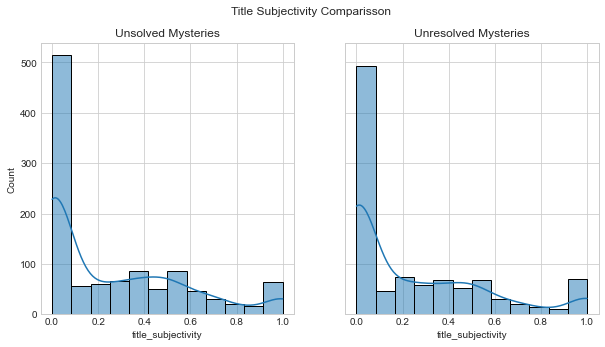

In [419]:
# With help from https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(data[data['subreddit'] == 0], x='title_subjectivity', kde=True, ax=axs[0])
sns.histplot(data[data['subreddit'] == 1], x='title_subjectivity', kde=True, ax=axs[1])

fig.suptitle('Title Subjectivity Comparisson')
axs[0].set_title('Unsolved Mysteries')
axs[1].set_title('Unresolved Mysteries')
plt.savefig('../presentation/plots/title_subjectivity.png')
;

### EDA on the 'author' feature.

#### Author Value Counts

Let's check value counts to see if there are authors with many posts.

In [420]:
data['author'].value_counts()

HauntedSpy             114
[deleted]               40
AutoModerator           22
JustScratch9459         22
spiritoffff             22
                      ... 
jeremysbrain             1
jeffers0n_steelflex      1
Johnred5347              1
TrueCrime2202            1
woofwoofpack             1
Name: author, Length: 1251, dtype: int64

Now let's check for each subreddit.

In [421]:
data[data['subreddit'] == 0]['author'].value_counts()

HauntedSpy              114
spiritoffff              22
Particular-Intern-41     11
BitterRecover3379        11
MaddMysteries            11
                       ... 
Best_Needleworker_43      1
rodentfacedisorder        1
JourneyIntoTheMatrix      1
truecrimefan22            1
sjf-01                    1
Name: author, Length: 649, dtype: int64

In [422]:
data[data['subreddit'] == 1]['author'].value_counts()

[deleted]               30
JustScratch9459         22
AutoModerator           22
Main_Initiative         20
MistressGravity         11
                        ..
I_try_2271               1
ItsDrake2000             1
thatplantistoxic         1
AlteredSportsHistory     1
woofwoofpack             1
Name: author, Length: 635, dtype: int64

There are deleted authors, let's check how many those are.

In [423]:
data[data['author'] == '[deleted]'].shape

(40, 8)

Not many deleted authors and it does appear that some authors post consistently to a specific subreddit.

>Could go back to data collection and filter out posts with deleted author.

#### Author Visual Comparissons
Let's visualize post counts by author for each subreddit

''

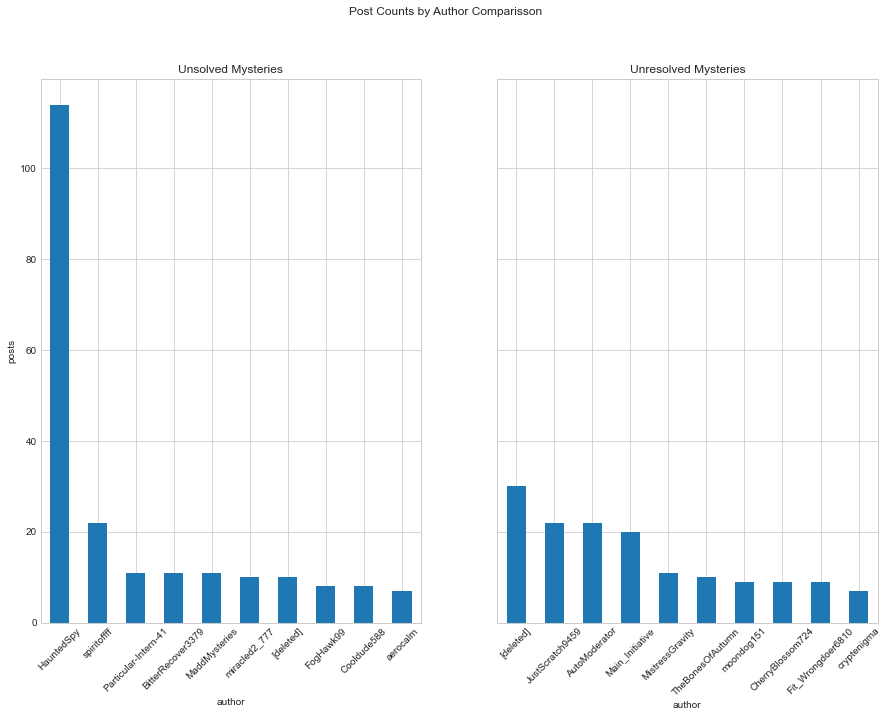

In [424]:
# With help from https://stackoverflow.com/questions/32244019/how-to-rotate-x-axis-tick-labels-in-a-pandas-plot
# and the pandas docs

# rename dataframe to avoid issues further down
authors = data
# add a post count 1 to sum when using groupby
authors['post_count'] = 1

fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)

unsol_auth = authors[authors['subreddit'] == 0].groupby('author').sum().sort_values(by='post_count', ascending=False).head(10)
unsol_auth['post_count'].plot(kind='bar', ax=axs[0], rot=45, ylabel='posts')


unresol_auth = authors[authors['subreddit'] == 1].groupby('author').sum().sort_values(by='post_count', ascending=False).head(10)
unresol_auth['post_count'].plot(kind='bar', ax=axs[1], rot=45, ylabel='posts')

fig.suptitle('Post Counts by Author Comparisson')
axs[0].set_title('Unsolved Mysteries')
axs[1].set_title('Unresolved Mysteries')
plt.savefig('../presentation/plots/authors.png')
;

### Author Summary Statistics

In [425]:
authors[authors['subreddit'] == 0].groupby('author').sum().sort_values(by='post_count', ascending=False)['post_count'].describe()

count    649.000000
mean       1.693374
std        4.669639
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      114.000000
Name: post_count, dtype: float64

In [426]:
authors[authors['subreddit'] == 1].groupby('author').sum().sort_values(by='post_count', ascending=False)['post_count'].describe()

count    635.000000
mean       1.587402
std        2.129076
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       30.000000
Name: post_count, dtype: float64

## Summary Statistics

In [427]:
data.describe()

,created_utc,subreddit,title_len,title_count,title_polarity,title_subjectivity,post_count
count,2.107000e+03,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.0
mean,1.635176e+09,0.478405,99.335548,16.843854,-0.015978,0.255522,1.0
std,5.428918e+06,0.499652,69.133024,12.282324,0.206963,0.306276,0.0
min,1.622510e+09,0.000000,1.000000,1.000000,-1.000000,0.000000,1.0
25%,1.632448e+09,0.000000,50.000000,8.000000,-0.066667,0.000000,1.0
50%,1.635985e+09,0.000000,79.000000,13.000000,0.000000,0.100000,1.0
75%,1.639200e+09,1.000000,126.000000,22.000000,0.000000,0.454545,1.0
max,1.643239e+09,1.000000,301.000000,61.000000,1.000000,1.000000,1.0


## EDA notes

The data seems to be fairly balanced and the numerical predictors are normally distributed. It appears this is a good dataset to use NLP and attempt to correctly classify the subreddit based on the words in the title of each post.

## Preprocessing

### Train-Test split
Start with 'title' only to build our baseline and first models

In [428]:
X = data['title']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1331)

### Baseline model
Count Vectorizer and Dummy Classifier

In [429]:
cv = CountVectorizer()
X_train_transformed = cv.fit_transform(X_train)
X_test_transfomed = cv.transform(X_test)

In [430]:
null_model = DummyClassifier()
null_model.fit(X_train_transformed, y_train)
null_model.score(X_test_transfomed, y_test)

0.5218216318785579

In [431]:
y_test.value_counts(normalize=True)

0    0.521822
1    0.478178
Name: subreddit, dtype: float64

### Baseline model for 'author'
Count Vectorizer and Dummy Classifier

In [432]:
X_auth = data['author']
y_auth = data['subreddit']

X_train_auth, X_test_auth, y_train_auth, y_test_auth = train_test_split(X_auth, y_auth, stratify=y_auth, random_state=1331)

In [433]:
cv = CountVectorizer()
X_train_auth_transformed = cv.fit_transform(X_train_auth)
X_test_auth_transfomed = cv.transform(X_test_auth)

In [434]:
null_model = DummyClassifier()
null_model.fit(X_train_auth_transformed, y_train_auth)
null_model.score(X_test_auth_transfomed, y_test_auth)

0.5218216318785579

In [435]:
y_test_auth.value_counts(normalize=True)

0    0.521822
1    0.478178
Name: subreddit, dtype: float64

## Grid Search Results Function
Print relevant GridSearch results and a Confusion Matrix

In [436]:
# Function to print GridSearch results
def gs_results(gs, X_test, y_test):
    print(f"Grid Search Best Training Set Score: {round(gs.best_score_,4)}")
    print('Best Grid Search Parameters:')
    for k, v in gs.best_params_.items():
        print(f"{k}: {v}")
    print(f"Grid Search Best Test Set Score: {round(gs.score(X_test, y_test),4)}")
    ConfusionMatrixDisplay.from_estimator(gs.best_estimator_,X_test, y_test, cmap='Blues');
        

## 'Title' Models
These are models built using 'title' as X.

### Naive Bayes and CountVectorizer Pipeline.

In [437]:
pipe = make_pipeline(CountVectorizer(stop_words='english'), MultinomialNB())

In [438]:
params = {
    'countvectorizer__stop_words': ['english'],
    'countvectorizer__min_df': [1, 2, 3],
    'countvectorizer__max_df': [.45, .55, .65],
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'multinomialnb__alpha': [1, 2, 3]
}

Grid Search Best Training Set Score: 0.6494
Best Grid Search Parameters:
countvectorizer__max_df: 0.45
countvectorizer__min_df: 1
countvectorizer__ngram_range: (1, 2)
countvectorizer__stop_words: english
multinomialnb__alpha: 1
Grid Search Best Test Set Score: 0.6528


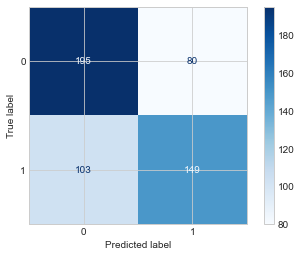

In [439]:
gs1 = GridSearchCV(pipe, params, n_jobs=-1)
gs1.fit(X_train, y_train)
gs_results(gs1, X_test, y_test)
plt.savefig('../presentation/plots/title_NB.png')


### LogisticRegression and CountVectorizer Pipeline.

In [440]:
pipe2 = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1_000))

In [441]:
pipe2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'logisticregression', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregr

In [442]:
params2 = {
    'countvectorizer__stop_words': ['english'],
    'countvectorizer__max_df': [.45, .55, .65],
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'logisticregression__C': [.01, .1, 1, 10, 100]
}

Grid Search Best Training Set Score: 0.6481
Best Grid Search Parameters:
countvectorizer__max_df: 0.45
countvectorizer__ngram_range: (1, 2)
countvectorizer__stop_words: english
logisticregression__C: 1
Grid Search Best Test Set Score: 0.6414


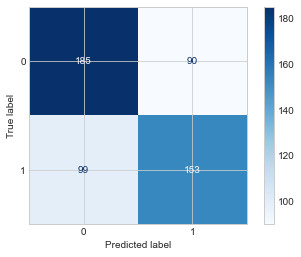

In [443]:
gs2 = GridSearchCV(pipe2, params2, n_jobs=-1)

gs2.fit(X_train, y_train)
gs_results(gs2, X_test, y_test)
plt.savefig('../presentation/plots/title_LR.png')

## 'Author' Models
These are models built using 'author' as X.

### Logistic Regression on 'author' feature.

In [444]:
X = data['author']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1331)

In [445]:
pipe3 = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1_000))

In [446]:
params3 = {
    'countvectorizer__stop_words': ['english'],
    'countvectorizer__max_df': [.45, .55, .35],
    'logisticregression__C': [.01, .1, 1, 10, 100]
}

Grid Search Best Training Set Score: 0.6924
Best Grid Search Parameters:
countvectorizer__max_df: 0.45
countvectorizer__stop_words: english
logisticregression__C: 0.1
Grid Search Best Test Set Score: 0.7514


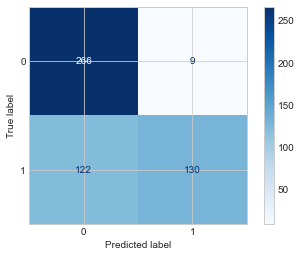

In [447]:
gs3 = GridSearchCV(pipe3, params3, n_jobs=-1)

gs3.fit(X_train, y_train)
gs_results(gs3, X_test, y_test)
plt.savefig('../presentation/plots/author_LR.png')

**Now that's a notable improvement using a basic model. It confirms some intuitions about certain people being regular posters to specific subreddits.**

### Decision Tree

In [448]:
pipe4 = make_pipeline(CountVectorizer(), DecisionTreeClassifier())

In [449]:
pipe4.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'decisiontreeclassifier', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_we

I've tried different values for the decissiontreeclassifier__max_depth param and iterating to see the best score changes

In [450]:
params4 = {
    'countvectorizer__stop_words': ['english'],
    'countvectorizer__max_df': [.45, .55, .35],
    'decisiontreeclassifier__max_depth': [500, 800, 1_000]
}

Grid Search Best Training Set Score: 0.6854
Best Grid Search Parameters:
countvectorizer__max_df: 0.45
countvectorizer__stop_words: english
decisiontreeclassifier__max_depth: 800
Grid Search Best Test Set Score: 0.7268


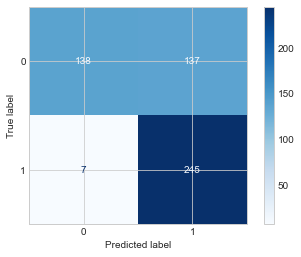

In [451]:
gs4 = GridSearchCV(pipe4, params4, n_jobs=-1)
gs4.fit(X_train, y_train)
gs_results(gs4, X_test, y_test)
plt.savefig('../presentation/plots/author_DT.png')

### Voting Classifier

In [454]:
pipe5 = make_pipeline(CountVectorizer(), VotingClassifier([('logreg', LogisticRegression()), ('decisiontree', DecisionTreeClassifier())]))

In [455]:
pipe5.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'votingclassifier', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'votingclassifier__estimators', 'votingclassifier__flatten_transform', 'votingclassifier__n_jobs', 'votingclassifier__verbose', 'votingclassifier__voting', 'votingclassifier__weights', 'votingclassifier__logreg', 'votingclassifier__decisiontree', 'votingclassifier__logreg__C', 'votingclassifier__logreg__class_weight', 'votingclassifier__logreg__dual', 'votingclassifier__logreg__fit_intercept', 'votingclas

In [456]:
params5 = {
    'countvectorizer__stop_words': ['english'],
    'countvectorizer__max_df': [.45, .55, .35],
    'votingclassifier__n_jobs': [-1],
    'votingclassifier__logreg__C': [.01, .1, 1, 10, 100],
    'votingclassifier__decisiontree__max_depth': [500, 800, 1_000]
}

Grid Search Best Training Set Score: 0.6924
Best Grid Search Parameters:
countvectorizer__max_df: 0.45
countvectorizer__stop_words: english
votingclassifier__decisiontree__max_depth: 500
votingclassifier__logreg__C: 0.1
votingclassifier__n_jobs: -1
Grid Search Best Test Set Score: 0.7514


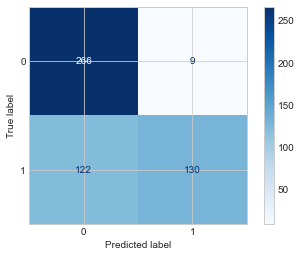

In [457]:
gs5 = GridSearchCV(pipe5, params5, n_jobs=-1)
gs5.fit(X_train, y_train)
gs_results(gs5, X_test, y_test)
plt.savefig('../presentation/plots/author_VC.png')